In [2]:
import gymnasium as gym
from gymnasium import spaces
from gymnasium.envs.registration import register
from gymnasium.utils.env_checker import check_env
import numpy as np
from typing import Optional, Union
import math

from gym.utils import seeding
import matplotlib.pyplot as plt
import random
import os

from matplotlib import patches, animation
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox
from matplotlib.collections import LineCollection
from matplotlib.path import Path
from matplotlib.lines import Line2D
from matplotlib.transforms import Affine2D

# To register this module as a gym envir
register(
    id='acasxu-v0',
    entry_point='acas_xu_env:AcasEnv'
)


def rad_mod(angle):
    """return angle between -pi and +pi"""
    return ( (angle + np.pi) % (np.pi*2) ) - np.pi

###############################################################################


def plot_state(encounter, fig=None, animate=False, frames=12, show=True):

    """own displacement in m in 10 seconds"""
    d_own = encounter.v_own/0.3281
    
    """int displacement in m in 10 seconds"""
    d_int = encounter.v_int/0.3281
    
    """intruder position"""
    x = encounter.rho * math.cos(encounter.theta)
    y = encounter.rho * math.sin(encounter.theta)
    
    """intruder displacement"""
    """psi = 0 means intruder flying in the same sense than own"""
    dx = d_int * np.cos(encounter.psi)
    dy = d_int * np.sin(encounter.psi)

    #lim = 2.3 * max(x, y)

    if fig is None:    
        fig, ax = plt.subplots()
    else:
        ax = fig.gca()
    
    #ax.set_xlim(-lim, lim)
    #ax.set_ylim(-lim, lim)

    """draw distance"""
    ax.annotate('', xytext=(x,y), xy=(0,0), arrowprops=dict(arrowstyle="-", linestyle="--", shrinkA=0, shrinkB=0, alpha=0.5))
    ax.annotate(f'$\\rho = {round(encounter.rho/1000,1)}$ Km', xy=(x//2 + encounter.v_own, y//2), xycoords='data')
    
    """ draw own speed"""
    ax.annotate('', xytext=(0,0), xy=(d_own,0), arrowprops=dict(arrowstyle='->'))
    ax.text(encounter.v_own, -2*encounter.v_own, str(round(d_own/1000,1)) + "Km in 10s")
    """draw own linear trajectory"""
    ax.annotate('', xy=(12*encounter.v_own,0), xytext=(0,0), arrowprops=dict(arrowstyle="-", linestyle=":", color='b', shrinkA=0, shrinkB=0, alpha=0.5))
    """draw intruder speed"""
    ax.annotate('', xytext=(x,y), xy=(x+dx,y+dy), arrowprops=dict(arrowstyle='->'))
    """draw own position"""
    ax.scatter(0, 0)
    ax.scatter(d_own, 0, alpha=0)
    """ draw intruder position"""
    ax.scatter(x, y)
    ax.scatter(x+dx, y+dy, alpha=0)
    
    """ draw intruder angle"""
    r = encounter.v_int
    arc_angles = np.linspace(0, encounter.psi, 20)
    arc_xs = r * np.cos(arc_angles)
    arc_ys = r * np.sin(arc_angles)
    ax.plot(arc_xs+x, arc_ys+y, lw = 1, color='k', alpha=0.5)
    ax.annotate(f'$\\psi = {round(np.degrees(encounter.psi),1)}\\degree$', xy=(x+encounter.v_int, y+encounter.v_int//2), xycoords='data')
    
    """draw intruder reference own heading"""
    ax.annotate('', xy=(x+2*encounter.v_int,y), xytext=(x,y), arrowprops=dict(arrowstyle="-", linestyle=":", color='g', shrinkA=0, shrinkB=0, alpha=0.5))

    """draw theta angle and annotation"""
    r = encounter.v_own
    arc_angles = np.linspace(0, encounter.theta, 20)
    arc_xs = r * np.cos(arc_angles)
    arc_ys = r * np.sin(arc_angles)
    ax.plot(arc_xs, arc_ys, lw = 1, color='k', alpha=0.5)
    ax.annotate(f'$\\theta = {round(np.degrees(encounter.theta),1)}\\degree$', xy=(encounter.v_own, encounter.v_own//2), xycoords='data')
    #plt.gca().annotate('<----- r = 1.5 ---->', xy=(0 - 0.2, 0 + 0.2), xycoords='data', fontsize=15, rotation = 45)
    
    ax.set_aspect('equal')
    
    ax.set_title("displacement (interval = $10s$)")
    
    if animate:
       """ draw own final position"""
       ax.scatter(frames*d_own, 0)
       """draw intruder final position"""
       ax.scatter(x+frames*dx, y+frames*dy)
    
       def animate(n):
          own_traj_coordinates = np.array([(0,0), ((n+1)*d_own, 0)])
          own_lines, = ax.plot(own_traj_coordinates[:,0], own_traj_coordinates[:,1], alpha=0.4, color='b')
          intruder_traj_coordinates = np.array([(x,y), (x+(n+1)*dx, y+(n+1)*dy)])
          intruder_lines, = ax.plot(intruder_traj_coordinates[:,0], intruder_traj_coordinates[:,1], alpha=0.4, color='g')
          return own_lines, intruder_lines
       
       anim = FuncAnimation(fig, animate, frames=frames, interval=500, repeat=False, blit=True)
    
    if show:
        plt.show()
    
    if animate:
        return anim
    else:
        return None
 

class Airplane():

    def __init__(self, x=0.0, y=0.0, head=0.0, speed=1.0, name='airplane'):
        self.x = x   
        self.y = y   
        self.head = head  # in rad
        self.speed = speed  # distance per unit of time (on heading direction)
        self.name=name
        self.last_a=0

    def __str__(self):
        return f"x: {self.x}, y: {self.y}, head: {self.head}, speed: {self.speed}"

# TODO supprimer ou modifier ? 
class Encounter:

    def __init__(self, *, last_a=0, v_own=50.0, v_int=0.0, theta=0.0, psi=0.0, rho=499., tau=0.0):
        #input values
        self.last_a = last_a #ça fait quoi ça ?  
        self.v_own = v_own   
        self.v_int = v_int
        self.theta = theta
        self.psi = psi
        self.rho = rho
        self.tau = tau

    def __getitem__(self, arg:str):
        return getattr(self, arg, None)

    def __str__(self):
        return  f"last_a={self.last_a}, v_own={self.v_own}, v_int={self.v_int}, theta={self.theta}, psi={self.psi}, rho={self.rho}, tau={self.tau}"


class AcasEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 60}

    act_to_angle = [0, np.radians(-1.5), np.radians(+1.5), np.radians(-3.), np.radians(+3.)]

    def __init__(self, 
                 save_states=False,
                 render_mode=None,
                 airplanes = [Airplane(name='own'), Airplane(x=5000.0, y=10.0, head=-3.0, name='intruder')],
                 epsilon = 153,
                 max_time_steps=200, step=0):
        self.last_a=0
        self.epsilon = epsilon
        self.airplanes = airplanes
        self.save_states=save_states # state save 
        self.states_history = [] # state history
        self.commands_history = [] # commands history
        self.own=airplanes[0]
        self.int = airplanes[1]
        self.rho = np.sqrt((self.own.x-self.int.x)**2 +(self.own.y-self.int.y)**2)
        self.min_dist = 0
        self.max_time_steps = max_time_steps
        

        #Initial values
        self.first_step = True
        self.done = False
        self.info = {}
        self.current_time_step = 0

        #ACTION DISCRETIZATION : 0,1,2,3,4 (COC, WR, WL, R, L) => we have 5 possible actions
        self.action_space = spaces.Discrete(5) 

        self.observation_space = spaces.Box(
           low=np.array([-1e6, 0, 0, -np.pi, -np.pi, 0]),
           high=np.array([1e6, 300, 300, np.pi, np.pi, 4]),
           dtype=np.float32
       )
      

        

    

    def __str__(self):
        return "\n".join([f"x: {airplane.x}, y: {airplane.y}, head: {airplane.head_rad}" for airplane in self.airplanes])

    
    def update_relations(self):

        # Could be a triangular matrix representation
        self.relative_distances = np.array([[np.hypot(own.x-intruder.x, own.y-intruder.y) for intruder in self.airplanes] for own in self.airplanes])
        for i in range(len(self.airplanes)):
            self.relative_distances[i,i] = np.inf
        self.nearest_intruder_index = self.relative_distances.argmin(axis=-1)
        self.relative_angles = np.array([[rad_mod(np.arctan2(intruder.y-own.y, intruder.x-own.x)) for intruder in self.airplanes] for own in self.airplanes])
        self.relative_heads = np.array([[rad_mod(intruder.head-own.head) for intruder in self.airplanes] for own in self.airplanes])
        #self.rho = np.array([np.sqrt((own.x-intruder.x)**2 +(own.y-intruder.y)**2) for intruder, own in self.airplanes])
        self.rho = np.array([self.relative_distances[i, self.nearest_intruder_index[i]] for i in range(len(self.airplanes))])
        self.theta = np.array([self.relative_angles[i, self.nearest_intruder_index[i]] for i in range(len(self.airplanes))])
        self.psi = np.array([self.relative_heads[i, self.nearest_intruder_index[i]] for i in range(len(self.airplanes))])
        self.v_int = np.array([self.airplanes[self.nearest_intruder_index[i]].speed for i in range(len(self.airplanes))])
        self.min_dist = self.rho.min()



    """
    Function to get the  observation of the state:
    rho :minimal distance between the planes,
    theta: angle of the ownship,
    psi: angle of the intruder,
    v_own: velocity of ownship, 
    v_int: velocity of intruder """

    def _get_obs(self):
        own = self.airplanes[0]
        intruder = self.airplanes[1]

        # Assurez-vous que les valeurs sont dans les limites de l'espace d'observation
            # Assurez-vous que les valeurs sont bien des scalaires
        rho = np.clip(self.rho[0], -1e4, 1e4)  # Prend la première valeur de rho
        own_speed = np.clip(own.speed, 0, 300)
        intruder_speed = np.clip(intruder.speed, 0, 300)
        theta = np.clip(self.theta[0], -np.pi, np.pi)  # Prend la première valeur de theta
        psi = np.clip(self.psi[0], -np.pi, np.pi)  # Prend la première valeur de psi
        last_a = np.clip(self.last_a, 0, 4)



        obs = np.array([rho, own_speed, intruder_speed, theta, psi, last_a], dtype=np.float32)
        return obs
   
    "Petite fonction get_info pour avoir la distance entre l'ownship et la destination finale A REFAIREE" #TODO
    def _get_info(self):
        own = self.airplanes[0]
        intruder = self.airplanes[1]
        
        info = {
        'own_position': (own.x, own.y),
         'intruder_position': (intruder.x, intruder.y),
         'distance_to_intruder': self.rho[0]
         }

        return(info)
    def reset(self,*, seed: Optional[int]=None, options: Optional[dict] =None):

        # we need this line to seed self.np_random
        super().reset(seed=seed)

        self.update_relations()
        
        observation = self._get_obs()
        info = {}
        #info = self._get_info()
        print("Observation:", observation)
        print("Observation Space:", self.observation_space)

        self.current_time_step=0
        if self.render_mode == "human":
            self.render()
        
        self.done=False

        return observation, info

    def step(self, action):
        """
        Make an action in the environnement. The action is chosen by the policy. 
        @type action : 
        @return : observation, truncated, terminated, info
        @rtype : obsType, Float, bool, bool, dict[str, Any]
        The observation space is a list of : rho, ownship's speed, intruder's speed, ownship's angle, Intruder's angle, minimum distance 
        between the two airplanes. 
        """
      
        own = self.airplanes[0]
        int=self.airplanes[1]


        own.head = rad_mod(own.head + self.act_to_angle[action])
        
        own.x += np.cos(own.head) * own.speed
        own.y += np.sin(own.head) * own.speed

        int.x+=np.cos(int.head) * int.speed
        int.y+=np.sin(int.head) * int.speed

        
        self.update_relations()

        self.current_time_step += 1
        #condition_reversal = (self.commands_history[-2]==1 and self.commands_history[-1]==2) or (self.commands_history[-2]==1 and self.commands_history[-1]==4) or (self.commands_history[-2]==1 and self.commands_history[-1]==2)
        
        reward=0

        if (action==0):
            reward +=0.0001
        elif ((self.last_a==1 and action==3)or (self.last_a==2 and action==4)):
            reward -= 0.009
        # Reversal
        # Right to left
        elif ((self.last_a==1 or self.last_a==3) and (action==2 or action==4)):
            reward -= 0.01
        # Left to right
        elif ((self.last_a==2 or self.last_a==4) and (action==3 or action==1)):
            reward -= 0.01
        elif self.rho[-1] < self.epsilon :
            reward = -1
        terminated = (self.rho[0] < self.epsilon)
        truncated =  (self.current_time_step == self.max_time_steps) #TODO time_steps == max  

        
        

        self.last_a=action
        obs = self._get_obs()
        info = self._get_info()
 
        return obs, reward, terminated, truncated, info


    def render(self, mode="human"):
        if not hasattr(self, 'fig'):
            # Créer une nouvelle figure et des axes
            self.fig, self.ax = plt.subplots()

            # Charger l'image de l'avion
            img_path = os.path.expanduser("~/Downloads/img_airplane.png")
            self.img_airplane = mpimg.imread(img_path)

            # Initialiser la configuration de la fenêtre
            self.ax.set_aspect('equal')
            self.ax.set_xlim(-10000, 10000)
            self.ax.set_ylim(-10000, 10000)

            # Listes pour stocker les points des trajectoires
            self.own_traj_x, self.own_traj_y = [], []
            self.intruder_traj_x, self.intruder_traj_y = [], []

        own = self.airplanes[0]
        intruder = self.airplanes[1]

        # Ajouter les positions actuelles aux listes des trajectoires
        self.own_traj_x.append(own.x)
        self.own_traj_y.append(own.y)
        self.intruder_traj_x.append(intruder.x)
        self.intruder_traj_y.append(intruder.y)

        # Efface l'ancienne image
        self.ax.clear()

        # Taille des images des avions
        img_size = 2000  # Ajuster cette valeur pour changer la taille des avions

        # Réafficher l'image de l'avion "own"
        self.img_airplane_obj = self.ax.imshow(self.img_airplane, extent=[own.x - img_size, own.x + img_size, own.y - img_size, own.y + img_size])

        # Réafficher l'image de l'avion "intruder"
        self.img_intruder_obj = self.ax.imshow(self.img_airplane, extent=[intruder.x - img_size, intruder.x + img_size, intruder.y - img_size, intruder.y + img_size])

        # Rotation des images selon les directions des avions
        trans_own = self.ax.transData.transform((own.x, own.y))
        trans_intruder = self.ax.transData.transform((intruder.x, intruder.y))
        rot_own = self.ax.transData.inverted().transform(trans_own + np.array([np.cos(own.head), np.sin(own.head)]) * 500) - np.array([own.x, own.y])
        rot_intruder = self.ax.transData.inverted().transform(trans_intruder + np.array([np.cos(intruder.head), np.sin(intruder.head)]) * 500) - np.array([intruder.x, intruder.y])

        angle_own = np.degrees(np.arctan2(rot_own[1], rot_own[0]))
        angle_intruder = np.degrees(np.arctan2(rot_intruder[1], rot_intruder[0]))

        self.img_airplane_obj.set_transform(self.ax.transData + Affine2D().rotate_deg_around(own.x, own.y, angle_own))
        self.img_intruder_obj.set_transform(self.ax.transData + Affine2D().rotate_deg_around(intruder.x, intruder.y, angle_intruder))

        # Tracer les trajectoires avec des points à intervalles réguliers
        if len(self.own_traj_x) % 5 == 0:  # Ajuster l'intervalle selon les besoins
            self.ax.plot(self.own_traj_x, self.own_traj_y, 'bo-', markersize=3, label='Ownship Trajectory')
            self.ax.plot(self.intruder_traj_x, self.intruder_traj_y, 'ro-', markersize=3, label='Intruder Trajectory')

        # Ajuster les limites des axes pour mieux centrer les avions
        self.ax.set_xlim(min(min(self.own_traj_x), min(self.intruder_traj_x)) - img_size * 2,
                         max(max(self.own_traj_x), max(self.intruder_traj_x)) + img_size * 2)
        self.ax.set_ylim(min(min(self.own_traj_y), min(self.intruder_traj_y)) - img_size * 2,
                         max(max(self.own_traj_y), max(self.intruder_traj_y)) + img_size * 2)

        if mode == "human":
            plt.draw()  # Met à jour le dessin
            plt.pause(0.001)  # Pause pour l'affichage






    def close(self):
        if hasattr(self, 'fig'):
            plt.close(self.fig)
            del self.fig
 

def smart_random_run(seed=True, total_time=120) :

    if seed is True :
        np.random.seed(50)
    airplanes=[]
    interest_time=random.randrange(40, total_time-40)

    
    head = np.random.uniform(-np.pi, +np.pi)
    speed = np.random.uniform(100, 300)
    x_t = 0
    y_t = 0
    x_0 = x_t - (speed * interest_time * np.cos(head))
    y_0 = y_t - (speed * interest_time * np.sin(head))

    airplanes.append(Airplane(x=x_0, y=y_0, head=head, speed=speed, name="own"))


    head = np.random.uniform(-np.pi, +np.pi)
    speed = np.random.uniform(100, 300)
    x_t = 0
    y_t = 0
    x_0 = x_t - (speed * interest_time * np.cos(head))
    y_0 = y_t - (speed * interest_time * np.sin(head))

    airplanes.append(Airplane(x=x_0, y=y_0, head=head, speed=speed, name="int"))

    env=AcasEnv(airplanes=airplanes)
    

    return(env)




/d/wabouir/miniforge3/lib/python3.10/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment acasxu-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [3]:
# Créer l'environnement
env = AcasEnv()

# Réinitialiser l'environnement pour obtenir une première observation
obs, info = env.reset()

# Afficher l'observation et vérifier si elle est dans l'espace d'observation

# Utiliser `check_env` pour valider l'environnement
from gymnasium.utils.env_checker import check_env
check_env(env)


Observation: [ 5.0000098e+03  1.0000000e+00  1.0000000e+00  1.9999973e-03
 -3.0000000e+00  0.0000000e+00]
Observation Space: Box([-1.0000000e+06  0.0000000e+00  0.0000000e+00 -3.1415927e+00
 -3.1415927e+00  0.0000000e+00], [1.0000000e+06 3.0000000e+02 3.0000000e+02 3.1415927e+00 3.1415927e+00
 4.0000000e+00], (6,), float32)
Observation: [ 5.0000098e+03  1.0000000e+00  1.0000000e+00  1.9999973e-03
 -3.0000000e+00  0.0000000e+00]
Observation Space: Box([-1.0000000e+06  0.0000000e+00  0.0000000e+00 -3.1415927e+00
 -3.1415927e+00  0.0000000e+00], [1.0000000e+06 3.0000000e+02 3.0000000e+02 3.1415927e+00 3.1415927e+00
 4.0000000e+00], (6,), float32)
Observation: [ 5.0000098e+03  1.0000000e+00  1.0000000e+00  1.9999973e-03
 -3.0000000e+00  0.0000000e+00]
Observation Space: Box([-1.0000000e+06  0.0000000e+00  0.0000000e+00 -3.1415927e+00
 -3.1415927e+00  0.0000000e+00], [1.0000000e+06 3.0000000e+02 3.0000000e+02 3.1415927e+00 3.1415927e+00
 4.0000000e+00], (6,), float32)
Observation: [ 5.00000

/d/wabouir/miniforge3/lib/python3.10/site-packages/gymnasium/utils/env_checker.py:321: UserWarning: WARN: Not able to test alternative render modes due to the environment not having a spec. Try instantialising the environment through gymnasium.make
  logger.warn(


In [4]:
def simulate_policy(env, policy):
    # Reset environment
    obs, _ = env.reset()
    
    positionsxown = []
    positionsyown = []
    positionsxint = []
    positionsyint = []
    while True  :
        action = policy(obs)  # Applique la politique pour obtenir l'action
        obs, reward, terminated, truncated, info = env.step(action)
        
        # Sauvegarder la position de l'avion (ou des avions)
        own_x, own_y = env.airplanes[0].x, env.airplanes[0].y
        int_x, int_y = env.airplanes[1].x, env.airplanes[1].y
        positionsxown.append(own_x)
        positionsyown.append(own_y)
        positionsxint.append(int_x)
        positionsyint.append(int_y)
        if terminated or truncated :
            break
        

    return positionsxown,positionsyown,positionsxint,positionsyint
        


Observation: [ 1.0000000e+04  2.2687497e+02  2.5359584e+02 -2.7391517e+00
 -1.5959600e+00  0.0000000e+00]
Observation Space: Box([-1.0000000e+06  0.0000000e+00  0.0000000e+00 -3.1415927e+00
 -3.1415927e+00  0.0000000e+00], [1.0000000e+06 3.0000000e+02 3.0000000e+02 3.1415927e+00 3.1415927e+00
 4.0000000e+00], (6,), float32)


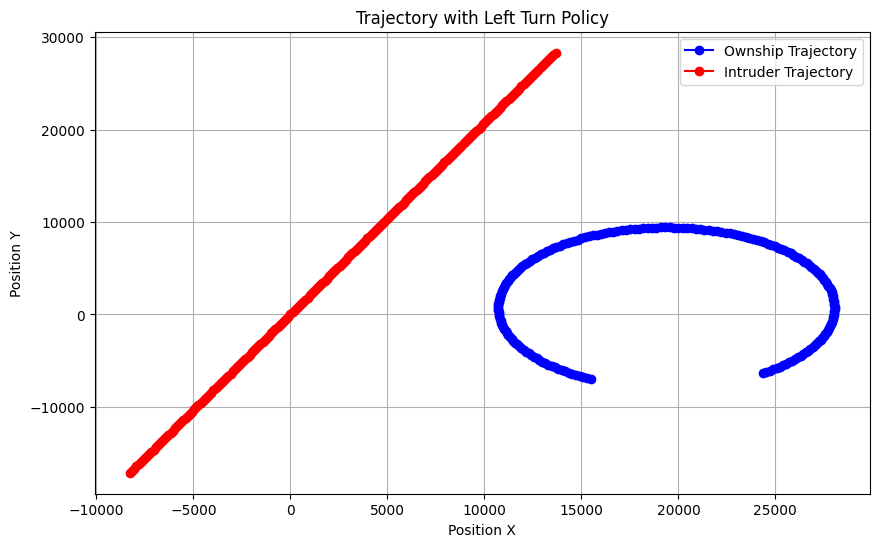

In [5]:
import matplotlib.pyplot as plt

# Politique de virage à gauche constant (action 1)
def left_turn_policy(obs):
    return 1  # Virage à gauche constant

# Exécuter et visualiser la politique
env = smart_random_run(seed=50)
left_positions = simulate_policy(env, left_turn_policy)

plt.figure(figsize=(10, 6))
plt.plot(left_positions[0], left_positions[1], 'bo-', label='Ownship Trajectory')
plt.plot(left_positions[2], left_positions[3], 'ro-', label='Intruder Trajectory')
plt.title("Trajectory with Left Turn Policy")
plt.xlabel('Position X')
plt.ylabel('Position Y')
plt.legend()
plt.grid(True)
plt.show()



In [6]:
import gymnasium
import numpy as np
import stable_baselines3 as sb3
from stable_baselines3 import PPO
from stable_baselines3 import A2C
import os
import PyFlyt.gym_envs
import random
import torch
import time

models_dir= f"models/PPO-{int(time.time())}"
logdir= f"logs/PPO-{int(time.time())}"

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)

env = AcasEnv()




term, trunc = False, False
env.reset()





model=PPO('MlpPolicy', env, verbose=1, tensorboard_log=logdir)
TIMESTEPS= 100000
for i in range(1,100):
    model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name="PPO")
    model.save(f"{models_dir}/{TIMESTEPS*i}")

2024-08-26 09:49:19.799075: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-26 09:49:20.096448: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-26 09:49:20.182446: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-26 09:49:20.768627: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-26 09:49:23.191633: W tensorflow/compiler/tf2

Observation: [ 4.9980210e+03  1.0000000e+00  1.0000000e+00  1.9620867e-03
 -3.0523598e+00  0.0000000e+00]
Observation Space: Box([-1.0000000e+06  0.0000000e+00  0.0000000e+00 -3.1415927e+00
 -3.1415927e+00  0.0000000e+00], [1.0000000e+06 3.0000000e+02 3.0000000e+02 3.1415927e+00 3.1415927e+00
 4.0000000e+00], (6,), float32)
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Observation: [ 4.9980210e+03  1.0000000e+00  1.0000000e+00  1.9620867e-03
 -3.0523598e+00  0.0000000e+00]
Observation Space: Box([-1.0000000e+06  0.0000000e+00  0.0000000e+00 -3.1415927e+00
 -3.1415927e+00  0.0000000e+00], [1.0000000e+06 3.0000000e+02 3.0000000e+02 3.1415927e+00 3.1415927e+00
 4.0000000e+00], (6,), float32)
Logging to logs/PPO-1724658567/PPO_0
Observation: [ 4.6233145e+03  1.0000000e+00  1.0000000e+00  9.4606075e-03
 -2.3716815e+00  4.0000000e+00]
Observation Space: Box([-1.0000000e+06  0.0000000e+00  0.0000000e+00 -3.1415927e+00
 -3.1415927e+00  0.0000000e